Firstly, mount the google drive.

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Downloading a pretrained model.

In [43]:
import torch
import torch.nn as nn
from torchvision import models
transfer_model = models.resnet50(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


Freeze all the layers except BatchNorm (which will be trained on the new dataset).

In [44]:
for name, param in transfer_model.named_parameters():
    if ("bn" not in name):
        param.requires_grad = False

Usually final classifier block in a PyTorch model is named as fc or classifier. In ResNet it's fc. Replace fc with a customized module, for the purpose of our own specified classification task.

In [45]:
transfer_model.fc = nn.Sequential(
    # details of these layers can be found in previous chapters
    nn.Linear(transfer_model.fc.in_features, 500),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(500, 2)
)

The following is exactly the same as in Chapter 2, fine tuning the network and check the result.

In [46]:
# PIL is a widely used python image library
import PIL
from PIL import Image, ImageFile

import torchvision
from torchvision import transforms
from torch.utils import data

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

# this is to prevent image file to be too large
ImageFile.LOAD_TRUNCATED_IMAGES = True 

workspace_path = "./drive/MyDrive/image_classification_test/"
train_data_path = workspace_path + "/train/"
val_data_path = workspace_path + "/val/"
test_data_path = workspace_path + "/test/"

# check if this image exists
img = Image.open(val_data_path + "/fish/100_1422.JPG")
print(img.size)

(512, 342)


In [47]:
# this function is very important, otherwise quite a few images won't be opened successfully, causing script's runtime error.
def check_image(path):
  try:
    Image.open(path)
    return True
  except:
    return False

img_transforms = transforms.Compose([
    transforms.Resize((64, 64)), # resize image
    transforms.ToTensor(), # store image data in tensor
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    # the above normalization follows distribution of ImageNet dataset
    ])

train_data = torchvision.datasets.ImageFolder(root = train_data_path, transform = img_transforms, is_valid_file=check_image)

val_data = torchvision.datasets.ImageFolder(root = val_data_path, transform = img_transforms, is_valid_file=check_image)

test_data = torchvision.datasets.ImageFolder(root = test_data_path, transform = img_transforms, is_valid_file=check_image)

# load data in a batch
batch_size = 64
train_data_loader = data.DataLoader(train_data, batch_size = batch_size)
val_data_loader = data.DataLoader(val_data, batch_size = batch_size)
test_data_loader = data.DataLoader(test_data, batch_size = batch_size)
# check how many images get loaded
print(len(train_data_loader.dataset))
print(len(val_data_loader.dataset))
print(len(test_data_loader.dataset))

803
110
160


In [48]:
import copy
my_model = copy.deepcopy(transfer_model)
# search for Adam optimizer for more info if needed
# note learning rate 3e-4 is quite famous, as it was recommended widely in academic research
# using a even smaller learning rate has a better chance to learn with small dataset
# using a larger learning rate would cause the network to learn very slowly
optimizer = optim.Adam(my_model.parameters(), lr = 0.0001)

# copy the model to device
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
my_model.to(device)

def loss_update(model, batch, loss_fn, device, check_result):
    inputs, targets = batch
    inputs = inputs.to(device)
    targets = targets.to(device)
    output = model(inputs)
    loss = loss_fn(output, targets)
    num_current_correct = 0
    if (check_result):
        result = torch.eq(torch.max(F.softmax(output, dim = 1), dim = 1)[1], targets)
        num_current_correct = torch.sum(result).item()
    return loss, num_current_correct

def train(model, optimizer, loss_fn, train_data_loader, val_data_loader, epochs, device):
  for epoch in range(epochs):
    training_loss = 0.0
    valid_loss = 0.0
    # this is to set model in training mode
    model.train()
    check_result = False
    # training process
    for batch in train_data_loader:
      optimizer.zero_grad()
      loss = loss_update(model, batch, loss_fn, device, check_result)[0]
      loss.backward()
      optimizer.step()
      training_loss += loss.data.item() * batch[0].shape[0]
    training_loss /= len(train_data_loader.dataset)

    # this is to set model in evaluation mode
    model.eval()
    check_result = True
    num_correct = 0
    num_examples = 0
    for batch in val_data_loader:
      loss, num_current_correct= loss_update(model, batch, loss_fn, device, check_result)
      valid_loss += loss.data.item() * batch[0].shape[0]
      num_correct += num_current_correct
      num_examples += batch[0].shape[0]
    valid_loss /= len(val_data_loader.dataset)

    print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss, valid_loss, num_correct / num_examples))

# modify the number of epochs to check how loss and accuracy changes with more training
# note this model needs a few more epochs to learn
train(my_model, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader, 100, device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0, Training Loss: 1.70, Validation Loss: 0.53, accuracy = 0.79
Epoch: 1, Training Loss: 0.57, Validation Loss: 0.83, accuracy = 0.21
Epoch: 2, Training Loss: 0.78, Validation Loss: 0.75, accuracy = 0.23
Epoch: 3, Training Loss: 0.73, Validation Loss: 0.69, accuracy = 0.58
Epoch: 4, Training Loss: 0.70, Validation Loss: 0.67, accuracy = 0.70
Epoch: 5, Training Loss: 0.69, Validation Loss: 0.67, accuracy = 0.72
Epoch: 6, Training Loss: 0.68, Validation Loss: 0.67, accuracy = 0.70
Epoch: 7, Training Loss: 0.67, Validation Loss: 0.67, accuracy = 0.64
Epoch: 8, Training Loss: 0.67, Validation Loss: 0.67, accuracy = 0.64
Epoch: 9, Training Loss: 0.66, Validation Loss: 0.67, accuracy = 0.64
Epoch: 10, Training Loss: 0.65, Validation Loss: 0.67, accuracy = 0.66
Epoch: 11, Training Loss: 0.65, Validation Loss: 0.66, accuracy = 0.70
Epoch: 12, Training Loss: 0.64, Validation Loss: 0.66, accuracy = 0.69
Epoch: 13, Training Loss: 0.63, Validation Loss: 0.67, accuracy = 0.68
Epoch: 14, Train

In [49]:
labels = ['cat', 'fish']
img = Image.open(test_data_path + "/fish/wilderness_beach.jpg")
img = img_transforms(img).to(device)
img = torch.unsqueeze(img, 0)
my_model.eval()
prediction = F.softmax(my_model(img), dim = 1)
print("prediction = ")
print(prediction)
prediction = prediction.argmax()
print("the prediction result is " + labels[prediction])

prediction = 
tensor([[1.9397e-05, 9.9998e-01]], grad_fn=<SoftmaxBackward>)
the prediction result is fish


Finding learning rate is often a necessary part in model training. fast.ai(https://www.fast.ai/) is a popular tool to help provide neural networks development easiness, and one of its features is the lr_finder(https://fastai1.fast.ai/callbacks.lr_finder.html). We are going to implement a simpler version of this lr_finder; in the future we will create a few new notebooks to study fast.ai thoroughly.

In [50]:
import math
def find_lr(model, loss_fn, optimizer, train_data_loader, init_value, final_value, device):
    data_len = len(train_data_loader) - 1
    update_step = (final_value / init_value) ** (1.0 / data_len)
    print("update_step = ")
    print(update_step)
    lr = init_value
    # search for optimizer.param_groups for more info if needed
    optimizer.param_groups[0]["lr"] = lr
    min_loss = 0.0
    batch_cnt = 0
    losses = []
    log_lrs = []

    check_result = False

    for batch in train_data_loader:
        batch_cnt += 1
        optimizer.zero_grad()
        loss, _ = loss_update(model, batch, loss_fn, device, check_result)

        if batch_cnt > 1 and loss > 4 * min_loss:
            break
        if batch_cnt == 1 or loss < min_loss:
            min_loss = loss
        losses.append(loss.item())
        log_lrs.append(lr)
        loss.backward()
        optimizer.step()

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    
    if (len(log_lrs) > 20):
        return log_lrs[10 : -5], losses[10 : -5]
    else:
        return log_lrs, losses  
  

Run the following to plot the finding lr result

update_step = 
5.62341325190349


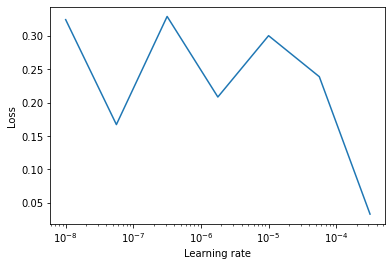

In [51]:
import matplotlib.pyplot as plt

(lrs, losses) = find_lr(my_model, torch.nn.CrossEntropyLoss(), optimizer, train_data_loader, 1e-8, 10.0, device)
plt.plot(lrs, losses)

plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()
# learning rate's best region can be found in https://blog.dataiku.com/the-learning-rate-finder-technique-how-reliable-is-it

Another approach is to customize each layer's learning rate. Firstly we unfreeze a few layers in the model:

In [52]:
my_diff_lr_model = copy.deepcopy(transfer_model)
my_diff_lr_model.to(device)

unfreeze_layers = [my_diff_lr_model.layer3, my_diff_lr_model.layer4]
for layer in unfreeze_layers:
    for param in layer.parameters():
        param.requires_grad = True

Then the optimizer can be customized to optimize different layers with differential learning rates (check https://towardsdatascience.com/transfer-learning-using-differential-learning-rates-638455797f00 for why this helps in deep learning).

In [53]:
lr_to_use = 0.0001
my_diff_lr_optimizer = optim.Adam([
    {'params' : my_diff_lr_model.layer4.parameters(), 'lr' : lr_to_use / 3},
    {'params' : my_diff_lr_model.layer3.parameters(), 'lr' : lr_to_use / 9},
    ], lr = 0.0001)

Now test and check the traing process (to save test time, run fewer epochs this time):

In [54]:
train(my_diff_lr_model, my_diff_lr_optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader, 20, device)

Epoch: 0, Training Loss: 0.72, Validation Loss: 0.61, accuracy = 0.78
Epoch: 1, Training Loss: 0.63, Validation Loss: 0.60, accuracy = 0.77
Epoch: 2, Training Loss: 0.59, Validation Loss: 0.60, accuracy = 0.79
Epoch: 3, Training Loss: 0.56, Validation Loss: 0.59, accuracy = 0.80
Epoch: 4, Training Loss: 0.53, Validation Loss: 0.59, accuracy = 0.82
Epoch: 5, Training Loss: 0.50, Validation Loss: 0.58, accuracy = 0.82
Epoch: 6, Training Loss: 0.48, Validation Loss: 0.58, accuracy = 0.82
Epoch: 7, Training Loss: 0.46, Validation Loss: 0.58, accuracy = 0.84
Epoch: 8, Training Loss: 0.44, Validation Loss: 0.58, accuracy = 0.86
Epoch: 9, Training Loss: 0.42, Validation Loss: 0.58, accuracy = 0.86
Epoch: 10, Training Loss: 0.41, Validation Loss: 0.58, accuracy = 0.86
Epoch: 11, Training Loss: 0.40, Validation Loss: 0.58, accuracy = 0.86
Epoch: 12, Training Loss: 0.38, Validation Loss: 0.57, accuracy = 0.86
Epoch: 13, Training Loss: 0.36, Validation Loss: 0.57, accuracy = 0.85
Epoch: 14, Train

In the following we are going to try out a few different image transform techniques. They can be used to enrich the data loader. To save running resources, we are only going to demonstrate the transforming effect, while not applying them in the training.

img_original


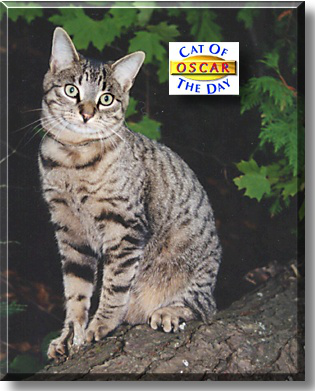

In [55]:
from PIL import Image
from IPython.display import display

workspace_path = "./drive/MyDrive/image_classification_test/"
train_data_path = workspace_path + "/train/"
val_data_path = workspace_path + "/val/"
test_data_path = workspace_path + "/test/"

img_original = Image.open(train_data_path + "/cat/19.jpg")
print("img_original")
display(img_original)


img_norm


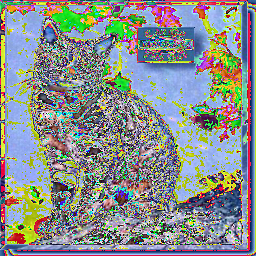

In [56]:
import torchvision
from torchvision import transforms
img_transforms_norm = transforms.Compose([
    transforms.Resize((256, 256)), # resize image
    transforms.ToTensor(), # store image data in tensor
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    # the above normalization follows distribution of ImageNet dataset
    ])
img_norm = transforms.ToPILImage()(img_transforms_norm(img_original))
print("img_norm")
display(img_norm)


img_colorjitter


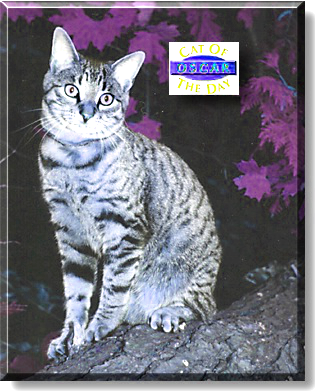

In [57]:
img_colorjitter = transforms.ColorJitter(brightness = 0.5, contrast = 0.5, saturation = 0.5, hue = 0.5)(img_original)
print("img_colorjitter")
display(img_colorjitter)

img_horizontalflip


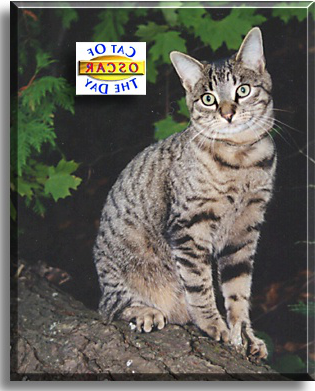

In [58]:
# setting p = 1.0 to force the transform to take effect
img_horizontalflip = transforms.RandomHorizontalFlip(p = 1.0)(img_original)
print("img_horizontalflip")
display(img_horizontalflip)

img_verticalflip


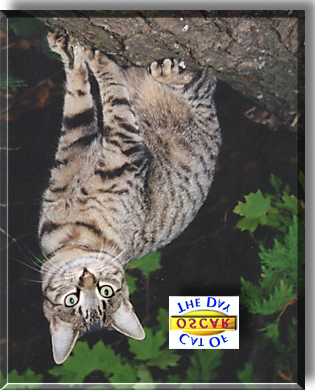

In [59]:
# setting p = 1.0 to force the transform to take effect
img_verticalflip = transforms.RandomVerticalFlip(p = 1.0)(img_original)
print("img_verticalflip")
display(img_verticalflip)

img_grayscale


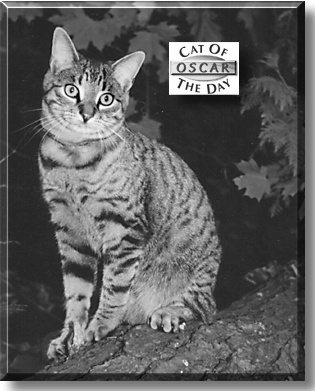

In [60]:
# setting p = 1.0 to force the transform to take effect
img_grayscale = transforms.RandomGrayscale(p = 1.0)(img_original)
print("img_grayscale")
display(img_grayscale)

img_crop


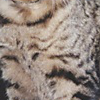

In [61]:
img_crop = transforms.RandomCrop(size = 100)(img_original)
print("img_crop")
display(img_crop)

img_resizedcrop


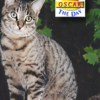

In [62]:
# search for the difference between RandomCrop and RandomResizedCrop if needed
img_resizedcrop = transforms.RandomResizedCrop(size = 100)(img_original)
print("img_resizedcrop")
display(img_resizedcrop)

img_rotation


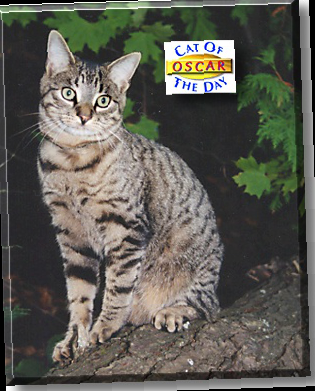

In [63]:
img_rotation = transforms.RandomRotation(degrees = 30)(img_original)
print("img_rotation")
display(img_rotation)

img_pad


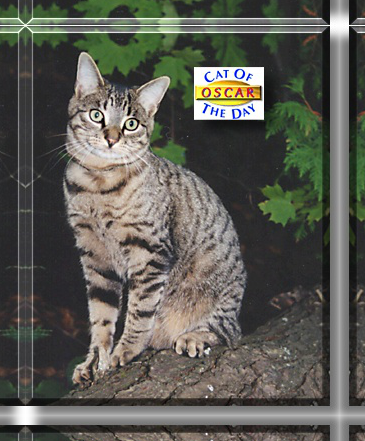

In [64]:
img_pad = transforms.Pad(padding = 25, fill = 0, padding_mode = 'reflect')(img_original)
print("img_pad")
display(img_pad)

img_affine


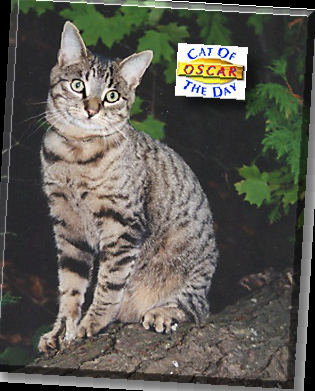

In [65]:
img_affine = transforms.RandomAffine(degrees = 30)(img_original)
print("img_affine")
display(img_affine)

The following is an example of custom transform function:

img_random_color_space


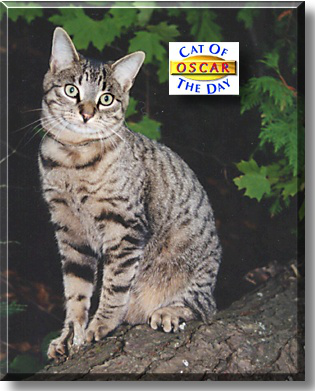

In [66]:
def _random_color_space(x):
    return x.convert("HSV")

color_transform = transforms.Lambda(lambda x : _random_color_space(x))
# this shows the usage of RandomApply for setting transformation's probability to occur
random_color_transform = transforms.RandomApply([color_transform], p = 1.0)
img_random_color_space = random_color_transform(img_original)
print("img_random_color_space")
# note to display an image in HSV, converting to RGB is needed..
# this just proves the conversion works..
display(img_random_color_space.convert("RGB"))

To get a more complicated custom transformation, simple define a class which implements __call__ and __repr__ (the string representing the transform).

Compose(
    this is a transform to mask out R
)
img_rmask


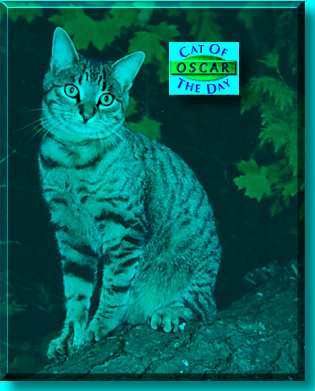

In [67]:
class RMask:
    def __init__(self):
        return
    def __repr__(self):
        return "this is a transform to mask out R"
    def __call__(self, img):
        r, g, b = img.split()
        r = r.point(lambda i: 0)
        return Image.merge('RGB', (r, g, b))
        

rmask_transform = transforms.Compose([RMask()])
print(rmask_transform)

img_rmask = rmask_transform(img_original)
print("img_rmask")
display(img_rmask)

The following code shows how to enhance the model with larger image size:

In [76]:
# continued from previous training
img_resized_transforms = transforms.Compose([
    # note previous training is on database of image size = 64x64
    transforms.Resize((128, 128)), # resize image
    transforms.ToTensor(), # store image data in tensor
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    # the above normalization follows distribution of ImageNet dataset
    ])
# use this image transformation to get new data loader and continue training
# we won't write the code here as the process is trivial

In the following we show an example of combining different models to get a voted result of prediciton. This technique is called Ensembling.

In [78]:
def run_prediction(model, img, device):
    img = img_transforms(img).to(device)
    img = torch.unsqueeze(img, 0)
    model.eval()
    prediction = F.softmax(model(img), dim = 1)
    print("prediction = ")
    print(prediction)
    return prediction

# note we already have two models: my_model and my_diff_lr_model. 
# You can also take advantage of models obtained from previous chapters.
labels = ['cat', 'fish']
img = Image.open(test_data_path + "/fish/wilderness_beach.jpg")
prediction1 = run_prediction(my_model, img, device)
prediction2 = run_prediction(my_diff_lr_model, img, device)
predictions = [prediction1, prediction2]
print(predictions)

avg_prediction = torch.stack(predictions).mean(0).argmax()
print("avg_prediction is ")
print(avg_prediction)
print(labels[avg_prediction])

prediction = 
tensor([[0.0012, 0.9988]], grad_fn=<SoftmaxBackward>)
prediction = 
tensor([[0.2722, 0.7278]], grad_fn=<SoftmaxBackward>)
[tensor([[0.0012, 0.9988]], grad_fn=<SoftmaxBackward>), tensor([[0.2722, 0.7278]], grad_fn=<SoftmaxBackward>)]
avg_prediction is 
tensor(1)
fish
